# Univ. of Illinois Data Mining Project on Coursera
## Task 01 - Initial Topic Investigation
2018-09-16
loganjtravis@gmail.com (Logan Travis)

In [1]:
# Imports
from collections import OrderedDict
import os, pickle, random
import gensim.models as models, gensim.matutils as matutils, \
        gensim.corpora as corpora
import matplotlib.pyplot as plot
import nltk
import pandas as pd
import pyLDAvis.gensim
from scipy.sparse import load_npz, save_npz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import MDS

/home/loganjtravis/miniconda3/envs/uoi-capstone/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/home/loganjtravis/miniconda3/envs/uoi-capstone/lib/python3.7/site-packages/funcy/colls.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable, Iterator, defaultdict
/home/loganjtravis/miniconda3/envs/uoi-capstone/lib/python3.7/site-packages/funcy/colls.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable, Iterator, defaultdict
/home/loganjtravis/miniconda3/envs/uoi-capstone/lib/python3.7/site-packages/funcy/fl

In [2]:
# Set random seed for repeatability
random.seed(42)

In [3]:
# Set matplotlib to inline to preserve images in PDF
%matplotlib inline

### Summary

From course page [Week 1 > Task 1 Information > Task 1 Overview](https://www.coursera.org/learn/data-mining-project/supplement/z2jpZ/task-1-overview):

> The goal of this task is to explore the Yelp data set to get a sense about what the data look like and their characteristics. You can think about the goal as being to answer questions such as:
> 
> 1. What are the major topics in the reviews? Are they different in the positive and negative reviews? Are they different for different cuisines?
> 2. What does the distribution of the number of reviews over other variables (e.g., cuisine, location) look like?
> 3. What does the distribution of ratings look like?
>
> In general, you can address such questions by showing visualization of statistics computed based on the data set or topics extracted from review text.

### Grading Rubric

From course page [Week 1 > Task 1 Information > Task 1 Rubric](https://www.coursera.org/learn/data-mining-project/supplement/Xk8lq/task-1-rubric):

> You will evaluate your peers' submission for Task 1 using this rubric. While evaluating, consider the following questions:
> 
> * Application of a topic model: Was the description of the topic modeling procedure clear enough such that you can produce the same results?
> * Topic visualization: Does the topic visualization effectively display the data?
> * Data exploration: Was the description of the two sets of data they selected for comparison clear enough to follow?
> * Visualization comparison: Does the visualization component highlight the differences/similarities between the data?
> 
> Note that the examples listed in the "Excellent" column are not an exclusive list for each category. You may choose to award 6 points for any effort in your peers' submissions that goes beyond what is required.
> 
> | Criteria | Poor (1 point) | Fair (3 points) | Good (5 points) | Excellent (6 points) |
> | --- | --- | --- | --- | --- |
> | **Task 1.1: Application of a topic model** | A topic model was either not used or did not generate any topic. | A topic model was used, but the report fails to mention what model was used and/or how it is applied to the data set. | The report clearly explains what topic model was used and how it was applied to the data set. | For example, multiple topic models were used and the report analyzes the differences between them. |
> | **Task 1.1: Generated visualization** | The visualization is either absent or useless. | The visualization is present but does not help make clear what topics the people have talked about in the reviews. | The visualization clearly shows and distinguishes what topics people have talked about in the reviews. | For example, multiple visualizations were used and the report analyzes the comparative strengths of each.
> | **Task 1.2: Generated sets of topics** | The two subsets are not comparable. | The two subsets are comparable. A topic model was used on the two subsets, but the report fails to mention what model was used and/or how it was applied to the data set. | The two subsets are comparable. The report clearly explains what topic model was used and how it was applied to the two subsets. | For example, multiple interesting subsets were identified and assessed for their usefulness, or multiple topic models were applied to the two subsets with differences between them analyzed.
> | **Task 1.2: Visualization of comparison** | The two subsets are visualized in such a way that similarities and differences are not clear. | The two subsets are visualized in such a way to show the similarity of the two subsets, but no attempt was made to show the differences. | The two subsets are visualized in such a way that both similarities and differences are very apparent. | Extra transformation of the data was done to improve visualization, or multiple ways of visualizing the topics were used to provide a very comprehensive comparison.
> | **Visualizations: Appropriateness of choice** | The visualization methods are not suitable for the type of data. | The visualization methods are suitable for the type of data, but another way to visualize the data is clearly better. | The visualization methods used are quite suitable for the type of data and made relationships clear. | Furthermore, extra effort was made to make the visualizations beautifully designed and/or usefully interactive.

### Get Yelp Review Data Set

I cleaned the Yelp review data in separate notebook to shorten this report. "Cleaned" only means:

* Reading the JSON file into a Pandas dataframe
* Expanding the `votes` feature which was nested JSON into separate features:
    * `votes_cool`
    * `votes_funny`
    * `votes_useful`
* Saving the final data frame to a pickle for easy loading

In [4]:
# Set paths to data source, work in process ("WIP"), and output
PATH_SOURCE = "source/"
PATH_WIP = "wip/"
PATH_OUTPUT = "output/"

# Set review file path
PATH_SOURCE_YELP_REVIEWS = PATH_SOURCE + \
        "yelp_academic_dataset_review.pkl.gzip"
PATH_WIP_TOKENIZER = PATH_WIP + "task01_tokenizer.pkl"
PATH_WIP_TOKEN_MATRIX = PATH_WIP + "task01_token_matrix.npz"
PATH_WIP_LDA_MODEL = PATH_WIP + "taks01_lda_model"

In [5]:
# Read pickled dataframe
dfYelpReviews = pd.read_pickle(PATH_SOURCE_YELP_REVIEWS)

In [6]:
# Print dataframe shape and head
print(f"Shape: {dfYelpReviews.shape}")
dfYelpReviews.head()

Shape: (1125458, 9)


,business_id,date,stars,text,type,user_id,votes_cool,votes_funny,votes_useful
review_id,,,,,,,,,
15SdjuK7DmYqUAj6rjGowg,vcNAWiLM4dR7D2nwwJ7nCA,2007-05-17,5,dr. goldberg offers everything i look for in a...,review,Xqd0DzHaiyRqVH3WRG7hzg,1,0,2
RF6UnRTtG7tWMcrO2GEoAg,vcNAWiLM4dR7D2nwwJ7nCA,2010-03-22,2,"Unfortunately, the frustration of being Dr. Go...",review,H1kH6QZV7Le4zqTRNxoZow,0,0,2
-TsVN230RCkLYKBeLsuz7A,vcNAWiLM4dR7D2nwwJ7nCA,2012-02-14,4,Dr. Goldberg has been my doctor for years and ...,review,zvJCcrpm2yOZrxKffwGQLA,1,0,1
dNocEAyUucjT371NNND41Q,vcNAWiLM4dR7D2nwwJ7nCA,2012-03-02,4,Been going to Dr. Goldberg for over 10 years. ...,review,KBLW4wJA_fwoWmMhiHRVOA,0,0,0
ebcN2aqmNUuYNoyvQErgnA,vcNAWiLM4dR7D2nwwJ7nCA,2012-05-15,4,Got a letter in the mail last week that said D...,review,zvJCcrpm2yOZrxKffwGQLA,1,0,2


### Calculate TF-IDF

I separated calculating TF-IDF from building models. The [GenSim package](https://radimrehurek.com/gensim/index.html) includes several models (e.g., [LDA](https://radimrehurek.com/gensim/models/ldamodel.html), [random projections](https://radimrehurek.com/gensim/models/rpmodel.html), and [LSI](https://radimrehurek.com/gensim/models/lsimodel.html)) that all accepts a TF-IDF matrix as input. **However**, I had to make early parameter decisions to keep the data size manageable (using an AWS EC2 t3.large instance). My first LDA model ran out of memory!

I therefore tested againts a tiny subset (0.1%) of the Yelp reviews. After producing several LDA models (my focus), I determined a reasonble set of constraints for TF-IDF:

* Limit maximum tokens (more on "tokens" versus "words" below) to 10,000. This is an extreme upper limit. The SciKit Learn `TfidfVectorizer` class ([link to documentation](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)) never yielded more than 5,000 tokens based on my other parameters. Most runs identifies approx. 1,000 tokens.
* Exclude tokens appearing in more than 50% of documents. These add very little to differntiating topics.
* Exclude tokens appearing in less than 1% of documents. I tested many settings for this parameter ranging down to 2 documents an up to 10% of all documents. The Yelp reviews include numerious limited-use terms (e.g., people and place names). I found it difficult to interpret the resulting topics with too many present.

In [7]:
# Set flag to load token matrix from file if found; set this to
# False when changing other parameters
load_token_matrix_from_file = False
overwrite_saved_token_matrix = not load_token_matrix_from_file

# Set token limit
max_features = 10000

# Set document frequency ceiling; topic analysis will ignore
# words found in more documents
max_df = 0.5

# Set document frequency floor; topic analysis will ignore
# words found in fewer document
min_df = 0.01

#### Custom Tokenizer

The SciKit Learn `TfidfVectorizer` class has a default pre-processor and tokenizer. While the pre-processing steps met my needs the tokenizer does not lemmatize nor stem words. Those two additional steps produced more stable topics. I therefore created my own tokenizer.

**Note:** I created `MyTokenizer` as a class to internalize instantiation of NLK's `WordNetLemmatizer` ([link to documentation](https://www.nltk.org/api/nltk.stem.html?highlight=wordnetlemmatizer#nltk.stem.wordnet.WordNetLemmatizer)).

In [8]:
class MyTokenizer:
    def __init__(self):
        """String tokenizer utilizing lemmatizing and stemming."""
        self.wnl = nltk.stem.WordNetLemmatizer()
    
    def __call__(self, document):
        """Return tokens from a string."""
        return [self.wnl.lemmatize(token) for \
                        token in nltk.word_tokenize(document)]

In [9]:
# Create TF-IDF vectorizer 
vectorizer = TfidfVectorizer(max_features=max_features, \
                             max_df=max_df, min_df=min_df, \
                             stop_words="english", \
                             use_idf=True, \
                             tokenizer=MyTokenizer())

#### Excessive Data Set Size

Setting parameters to limit excessively in/frequent tokens helped to manage overall data size. Unfortunately, both proved insufficient to permit the LDA model to fit within the memory available on my machine. I therefore worked on a 30% sample of the Yelp review data set. You'll see my other mundane efforts to save time like saving significant outputs to file and printing processing times to console.

In [10]:
# Set working dataframe to a 30% sample of the full data set;
# too large otherwise
df = dfYelpReviews.sample(frac=0.05)

In [11]:
%%time
# Load token matrix and vectorizer from file if found and
# flag set to permit; otherwise vectorize documents
tokenMatrix = None
if(load_token_matrix_from_file and \
   os.path.isfile(PATH_WIP_TOKEN_MATRIX) and 
   os.path.isfile(PATH_WIP_TOKENIZER)):
    print(f"Loading token matrix from file \"{PATH_WIP_TOKEN_MATRIX}\"...")
    tokenMatrix = load_npz(PATH_WIP_TOKEN_MATRIX)
    
    print(f"Loading vectorizer from file \"{PATH_WIP_TOKENIZER}\"...")
    f = open(PATH_WIP_TOKENIZER, "rb")
    vectorizer = pickle.load(f)
    f.close()
else:
    print("Calculating TF-IDF to build token matrix...")
    tokenMatrix = vectorizer.fit_transform(df.text)
    overwrite_saved_token_matrix = True

Calculating TF-IDF to build token matrix...
CPU times: user 1min 20s, sys: 1.2 s, total: 1min 21s
Wall time: 1min 22s


In [12]:
# Print token matrix shape
print("Found {0[1]:,} tokens in {0[0]:,} documents".format(tokenMatrix.shape))

Found 903 tokens in 56,273 documents


In [13]:
# Save token matrix and vectorizer to file if changed
if(overwrite_saved_token_matrix):
    save_npz(PATH_WIP_TOKEN_MATRIX, tokenMatrix)
    f = open(PATH_WIP_TOKENIZER, "wb")
    pickle.dump(vectorizer, f)
    f.close()

### Find Topics Using LDA

I focused on Latent Dirichlet Allocation as my model of choice. I used it in other Coursera classes and feel comfortable with its basic premise.

Similar to calculating TF-IDF, I adjusted several parameters using a tiny subset (0.1%) of the Yelp reviews. **I don't think they're perfect.** Most of the resulting topics suggest real-world categories like nightclubs or pizza restaurants. Others less so. Still, these parameters work reasonably well:

* Set number of topics to 30
* Display topics using their 10 most frequent tokens

In [14]:
# Set flag to load LDA model from file if found; set this to
# False when changing other parameters
load_lda_model_from_file = True and load_token_matrix_from_file
overwrite_saved_lda_model = not load_lda_model_from_file

# Set number of topics
num_topics = 50

# Set number of words to display for each topic
num_words = 10

In [15]:
# Convert GenSim corpus from token vectors
corpus = matutils.Sparse2Corpus(tokenMatrix, documents_columns=False)

In [16]:
# Create a GenSim dictionary for documents; Note: Passes the
# vectorizer tokens as a single "document". I could think of
# no other way to assure they use the name identfiers.
dictionary = corpora.Dictionary([vectorizer.get_feature_names()])

In [17]:
%%time
# Load LDA model form file if found and flag set to permit;
# otherwise find topics
lda = None
if(load_lda_model_from_file and \
   os.path.isfile(PATH_WIP_LDA_MODEL)):
    print(f"Loading LDA model from \"{PATH_WIP_LDA_MODEL}\"...")
    lda = models.ldamulticore.LdaMulticore.load(PATH_WIP_LDA_MODEL)
else:
    print("Finding topics using LDA...")
    lda = models.ldamulticore.LdaMulticore(corpus, num_topics=num_topics, id2word=dict(dictionary.items()))
    overwrite_saved_lda_model = True

Finding topics using LDA...


/home/loganjtravis/miniconda3/envs/uoi-capstone/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/loganjtravis/miniconda3/envs/uoi-capstone/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/loganjtravis/miniconda3/envs/uoi-capstone/lib/python3.7/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generato

CPU times: user 13.6 s, sys: 1.69 s, total: 15.3 s
Wall time: 15 s


In [18]:
# Print a few topics for sanity check
lda.show_topics(num_topics=num_topics, num_words=num_words)[:5]

[(0,
  '0.010*"..." + 0.010*"\'s" + 0.009*"place" + 0.009*"n\'t" + 0.009*"pool" + 0.009*"?" + 0.009*"bar" + 0.009*")" + 0.008*"cool" + 0.008*"drink"'),
 (1,
  '0.024*"buffet" + 0.010*"food" + 0.009*"good" + 0.009*"\'s" + 0.009*"n\'t" + 0.008*"crab" + 0.008*")" + 0.008*"dessert" + 0.008*"(" + 0.006*"place"'),
 (2,
  '0.015*"food" + 0.012*"place" + 0.010*"good" + 0.010*"great" + 0.009*"\'s" + 0.009*"n\'t" + 0.008*"service" + 0.008*"time" + 0.008*"amazing" + 0.008*"grill"'),
 (3,
  '0.018*"pizza" + 0.012*"\'s" + 0.011*"place" + 0.010*"n\'t" + 0.009*"food" + 0.008*"good" + 0.007*")" + 0.007*"great" + 0.007*"(" + 0.007*"time"'),
 (4,
  '0.017*"rude" + 0.011*"employee" + 0.010*"school" + 0.010*"n\'t" + 0.009*"service" + 0.009*"place" + 0.009*"..." + 0.008*"food" + 0.008*"time" + 0.008*"customer"')]

In [19]:
# Save LDA model to file if changed
if(overwrite_saved_lda_model):
    lda.save(PATH_WIP_LDA_MODEL)

### Graphing Topics from LDA

Priting the most frequent tokens of topics as I did above provides a useful sanity check. However, it does not help clarify the relation between topics nor provide a means of exploring them. The *awesome* [pyLDAvis package](https://github.com/bmabey/pyLDAvis) does and includes easy integration with GenSim models.

...but I cannot save the output to PDF! Sorry. I really encourage you to check our pyLDAvis. For this assignment, I instead created scatter plots using the SciKit Learn `TSNE` class ([link to documentation](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)).

In [20]:
%%time
# Prepare visualization
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)

/home/loganjtravis/miniconda3/envs/uoi-capstone/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


CPU times: user 15.3 s, sys: 2.33 s, total: 17.6 s
Wall time: 18.5 s


In [21]:
# Display visualization
pyLDAvis.display(vis)

In [22]:
def getTopicTokenDistribution(model, topn=20):
    """Generate a matrix of topics (rows) by token distribution (columns)."""
    topic_token = []
    for topic in range(model.num_topics):
        dist = OrderedDict([(t, 0) for t in range(model.num_terms)])
        dist.update(dict(model.get_topic_terms(topic, topn=topn)))
        topic_token.append(list(dist.values()))
    return topic_token

topic_token_dist = getTopicTokenDistribution(lda)

In [23]:
mds = MDS(n_components=2)

In [24]:
# as dataframe to better support Bokeh
mds_topic_token = pd.DataFrame(mds.fit_transform(topic_token_dist))

/home/loganjtravis/miniconda3/envs/uoi-capstone/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


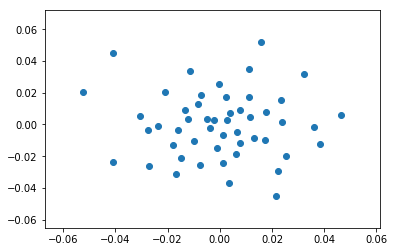

In [25]:
plot.scatter(x=mds_topic_token[0], y=mds_topic_token[1])
plot.show()